# De novo gene set identification

In this notebook, we identify *de novo* gene sets with mutually exclusive alterations. To do so, we cluster genes based on the results of the pairwise mutual exclusivity analysis. The resulting clusters are tested with the groupwise mutual exclusivity test.

In [1]:
import sys
sys.path.append("../lib")

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import networkx
import numpy
import scipy.sparse
import scipy.stats

In [4]:
import discover

In [5]:
import corclust

In [6]:
import nbsupport.io
import nbsupport.plots
import nbsupport.tcga

In [7]:
from collections import Counter
from itertools import combinations, imap, product

In [8]:
from nbsupport.stats import fdr
from pandas import match

## Data and results

We use the results of the pairwise mutual exclusivity analysis obtained in the notebook [Pairwise analysis](Pairwise analysis.ipynb).

In [9]:
dataFile = "../data/tcga/tcga-pancan12.h5"

In [10]:
result_mutex = nbsupport.io.load_pairwise_result(dataFile, "/results/mutex")

In [11]:
events = nbsupport.io.load_discover_matrix(dataFile, "/models/combined")

## Identification of candidate gene sets

To identify candidate gene sets to test for groupwise mutual exclusivity, we use the overlapping correlation clustering algorithm described by Bonchi et al.

> Bonchi, F., Gionis, A. & Ukkonen, A. Overlapping correlation clustering. *Knowledge and information systems* **35**, 1–32 (2013), [doi:10.1007/s10115-012-0522-9](http://doi.org/10.1007/s10115-012-0522-9).

This algorithms clusters the nodes (i.e. genes in our case) of a graph based on the presence/absence and weights of the edges between them. We will describe the way in which we compute the edge weights below.

### Edge weights

We compute our edge weights based on two features.

1. The strength of the mutual exclusivity of the two genes, as measured by the $P$-value.
2. The connectedness of the two genes: an edge between two genes with few edges to other genes will receive a higher weight than an edge between genes that are also connected to many other genes.

The edge weights are based on the model of Chang et al.

> Chang, Y.-T., Leahy, R. M. & Pantazis, D. Modularity-based graph partitioning using conditional expected models. *Physical Review E* **85**, 016109 (2012), [doi:10.1103/PhysRevE.85.016109](http://doi.org/10.1103/PhysRevE.85.016109).

Two genes are connected by an edge in the mutual exclusivity graph if they were found mutually exclusive at a maximum FDR of 10%.

In [12]:
with numpy.errstate(invalid="ignore"):
    observed_graph = networkx.Graph((numpy.asarray(result_mutex.qvalues) < 0.1).astype(int))

In the mutual exclusivity graph, an edge between two genes can be absent for two reasons. Either the two genes are located on the same chromosome (and thus were not tested), or the gene pair was tested but not found to be mutually exclusive. By specifying a permissible graph, we inform the model about whether edges are missing by design (located on the same chromosome), or missing because of no mutual exclusivity.

In [13]:
permissible_graph = networkx.Graph(numpy.isfinite(numpy.asarray(result_mutex.qvalues)).astype(int))

In [14]:
isolated_nodes = networkx.isolates(observed_graph)
permissible_graph.remove_nodes_from(isolated_nodes)
observed_graph.remove_nodes_from(isolated_nodes)

In [15]:
observed_edges = numpy.array([permissible_graph.edges().index(e) for e in observed_graph.edges_iter()])

We first compute $\Sigma_\mathrm{x}$, the edge weight covariance matrix. Our edge weights will be based on the pairwise mutual exclusivity $P$-values. Adjacent edges&mdash;which correspond to pairwise tests where one gene is tested in both&mdash;will have a non-zero covariance. Taking into account the mathematics behind the Poisson-Binomial test, this covariance for the edges *g1*-*g2* and *g2*-*g3* can be shown to be:

$\sum_{j=1}^n p_{g1,j} p_{g2,j} p_{g3,j} (1 - p_{g2,j})$

where $p_{i,j}$ is the alteration probability for gene $i$ in tumour $j$.

In [16]:
bg = events.bg

sigma_x = scipy.sparse.lil_matrix((permissible_graph.number_of_edges(),) * 2)

for i, genes in enumerate(permissible_graph.edges_iter()):
    sigma_x[i, i] = (bg[list(genes)].prod(0) * (1 - bg[list(genes)].prod(0))).sum()

for i, genes1 in enumerate(imap(set, permissible_graph.edges_iter())):
    for j, genes2 in enumerate(imap(set, permissible_graph.edges_iter())):
        if i > j and len(genes1 & genes2) > 0:
            sigma_x[i, j] = (bg[list(genes1 | genes2)].prod(0) * (1 - bg[list(genes1 & genes2)].prod(0))).sum() / (numpy.sqrt(sigma_x[i, i]) * numpy.sqrt(sigma_x[j, j]))
            sigma_x[j, i] = sigma_x[i, j]

for i, genes in enumerate(permissible_graph.edges_iter()):
    sigma_x[i, i] = 1

sigma_x = sigma_x.tocsr()

Since the model of Chang et al. assumes normally distributed edge weights, we transform the $P$-values using the Normal quantile function.

In [17]:
i, j = zip(*observed_graph.edges())
edge_weights = scipy.stats.norm.ppf(1 - numpy.asarray(result_mutex.pvalues)[i, j])

In [18]:
edge_weights[numpy.isnan(edge_weights)] = scipy.stats.norm.ppf(1 - numpy.asarray(result_mutex.pvalues)[j, i])[numpy.isnan(edge_weights)]

The cells below estimate the parameters described in the Chang et al. paper.

In [19]:
k = networkx.incidence_matrix(observed_graph).dot(edge_weights)

In [20]:
H = networkx.incidence_matrix(permissible_graph)

$\Sigma_{\mathrm{xk}} = \Sigma_\mathrm{x} \mathrm{H}^T$

In [21]:
sigma_xk = sigma_x.dot(H.T)

$\Sigma_\mathrm{k} = \mathrm{H} \Sigma_\mathrm{x} \mathrm{H}^T$

In [22]:
sigma_k = H.dot(sigma_x).dot(H.T)

$E(\mathrm{x} \mid \mathrm{Hx} = \mathrm{k}) = \mu_{\mathrm{x} \mid \mathrm{k}} = \mu_\mathrm{x} + \Sigma_\mathrm{xk} \Sigma_\mathrm{k}^{-1} (\mathrm{k} - \mu_\mathrm{k})$

where

$\Sigma_\mathrm{xk} = \Sigma_\mathrm{x} \mathrm{H}^T$

Moreover, under the null hypothesis, $\mu_\mathrm{x} = 0$. Therefore, the above expression reduces to:

$E(\mathrm{x} \mid \mathrm{Hx} = \mathrm{k}) = \Sigma_\mathrm{xk} \Sigma_\mathrm{k}^{-1} \mathrm{k}$

In [23]:
exp = sigma_xk.dot(scipy.sparse.linalg.inv(sigma_k)).dot(k)

To get the variance of the edge weight distributions, we estimate (part of) the conditional covariance matrix:

$\Sigma_{\mathrm{x} \mid \mathrm{k}} = \Sigma_\mathrm{x} - \Sigma_\mathrm{xk} \Sigma_\mathrm{k}^{-1} \Sigma_\mathrm{kx}$

In [24]:
sigma_k_inv = scipy.sparse.linalg.inv(sigma_k)

In [25]:
edge_variances = numpy.array([
        sigma_x[i, i] - sigma_xk[i].dot(sigma_k_inv).dot(sigma_xk[i].T)[0, 0]
        for i in xrange(permissible_graph.number_of_edges())])

### Clustering

From the computations in the previous section, we obtained&mdash;for each edge in the mutual exclusivity graph&mdash;an expected weight and a corresponding variance. We also have observed weights for all edges: the quantile-transformed $P$-values. The weights that we will use for the correlation clustering will now be the probability that the observed weight is greater than the expected weight, based on the Normal distribution.

In [26]:
weight_matrix = numpy.zeros(result_mutex.qvalues.shape)

for (i, j), mean, var, obs in zip(observed_graph.edges_iter(),
                                  exp[observed_edges],
                                  edge_variances[observed_edges],
                                  edge_weights):
    diff_dist = scipy.stats.norm(obs - mean, numpy.sqrt(1 + var))
    weight = diff_dist.sf(0)
    weight_matrix[i, j] = weight
    weight_matrix[j, i] = weight

for i, j in product(observed_graph.nodes_iter(), repeat=2):
    if i != j and result_mutex.qvalues.index[i].split("_")[0] == result_mutex.qvalues.columns[j].split("_")[0]:
        weight_matrix[i, j] = 1

Since genes located close to each other tend to have similar copy number profiles, they will also be mutually exclusive with similar sets of genes. This may lead to many clusters that are essentially equivalent, just with a different gene from the same genomic segment. To avoid this, we group genes if they are located in the same recurrently altered copy number segment.

In [27]:
segments = {}

for eventType in ["amp", "del"]:
    peaks = nbsupport.tcga.read_gistic_output("../data/tcga/%s_genes.conf_95.pancan12.txt" % eventType)
    segments.update({ gene.strip("[]"): "/".join([seg, eventType]) for seg in peaks for gene in peaks[seg] })

In [28]:
groups = networkx.Graph()

groups.add_nodes_from(events.rownames[observed_graph.nodes()])

for gene in events.rownames:
    if not gene.endswith("_mut"):
        groups.add_edge(gene, segments[gene.split("_")[0]])

for gene1, gene2 in combinations(events.rownames, 2):
    if gene1.split("_")[0] == gene2.split("_")[0]:
        groups.add_edge(gene1, gene2)

group_items = [
    x
    for x
    in [numpy.intersect1d(match(list(c.intersection(events.rownames)), events.rownames), observed_graph.nodes())
        for c in networkx.connected_components(groups)]
    if len(x) > 0]

In [29]:
grouped_weight_matrix = numpy.zeros((len(group_items),) * 2)
for i, group1 in enumerate(group_items):
    for j, group2 in enumerate(group_items):
        grouped_weight_matrix[i, j] = weight_matrix[group1[:, numpy.newaxis], group2].mean()

The clustering algorithm of Bonchi et al. is an approximate algorithm that is sensitive to the initial solution with which the algorithm is started. For this reason, we run the algorithm 100 times with random initial solutions and consider all gene clusters that are found more than two times.

In [30]:
numpy.random.seed(1234)

num_clusters = 50
clusters = Counter()

for i in xrange(100):
    result, cost = corclust.multiCorrClust(grouped_weight_matrix, num_clusters, 5, silent=True)
    clusters.update([tuple(sorted(i
                                  for i, labels
                                  in enumerate(map(lambda x: set(x.nonzero()[0]), result))
                                  if j in labels))
                     for j in xrange(num_clusters)])

In [31]:
gene_sets = [[events.rownames[group_items[i]].astype(str) for i in group]
             for group, count
             in clusters.iteritems()
             if count > 2]

## Groupwise tests

We test the gene sets obtained in the previous section, and show alteration plots for those groups that are found mutually exclusive at a maximum FDR of 1%.

In [32]:
def filter_gene_set(genes):
    mut = genes[numpy.char.endswith(genes, "_mut")]
    cn = genes[~numpy.char.endswith(genes, "_mut")]
    if len(cn) > 0:
        cn = cn[:1]
    return numpy.concatenate([mut, cn])

In [33]:
pValues = numpy.array(
    [discover.groupwise_discover_test(
            events[numpy.concatenate(map(filter_gene_set, genes))], "impurity")
     for genes in gene_sets])

Note that in the mutual exclusivity plots below, some genes have co-occurring rather than mutually exclusive alterations. These genes are located in the same copy numer segment and therefore have correlated alteration profiles.

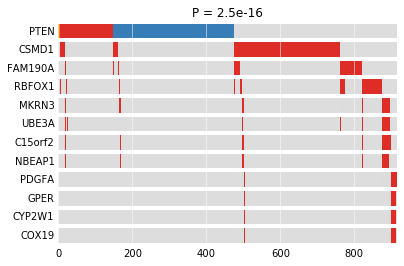

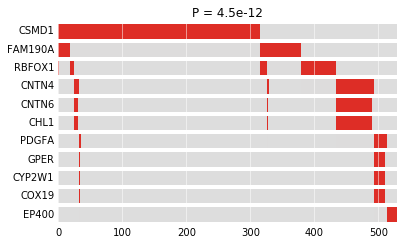

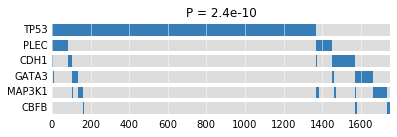

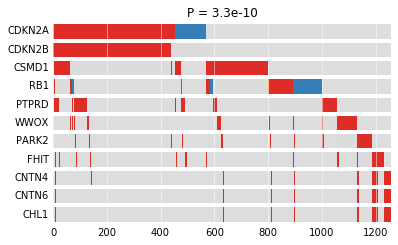

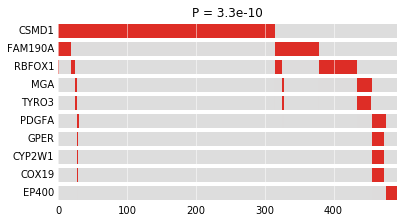

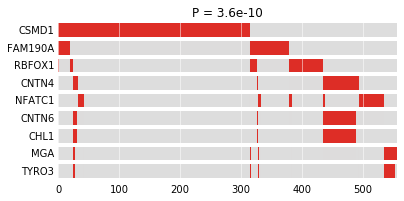

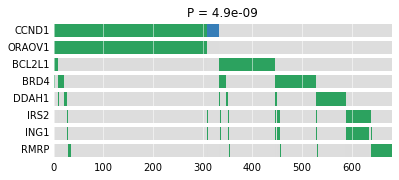

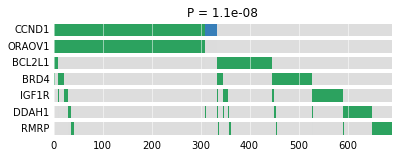

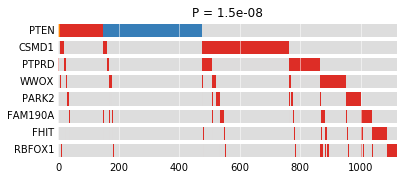

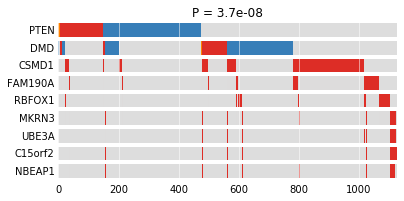

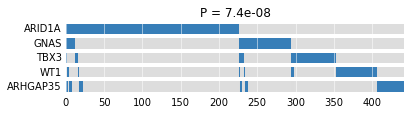

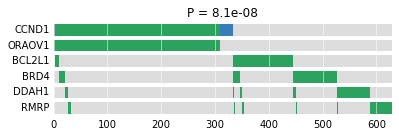

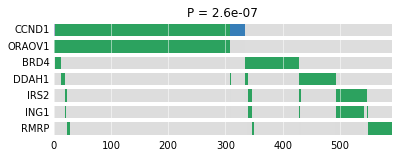

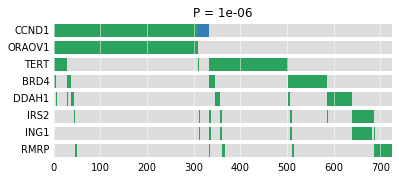

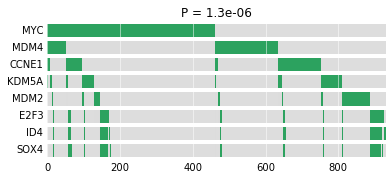

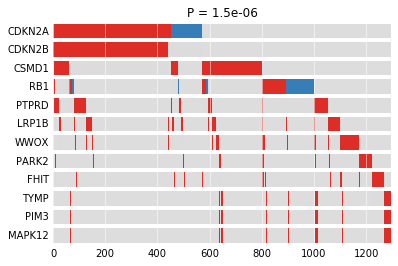

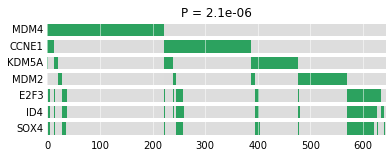

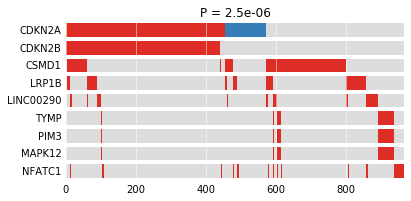

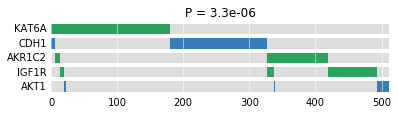

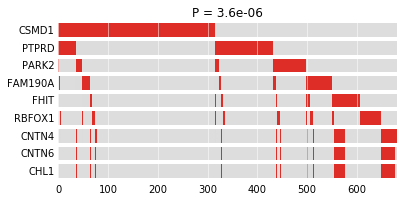

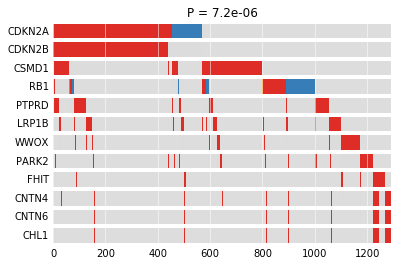

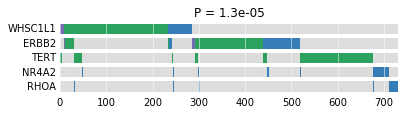

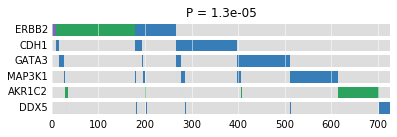

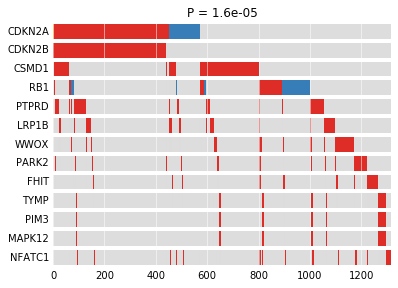

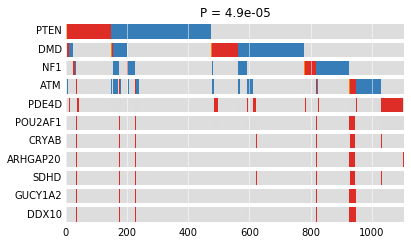

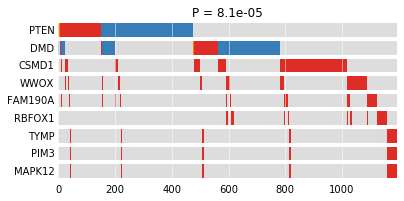

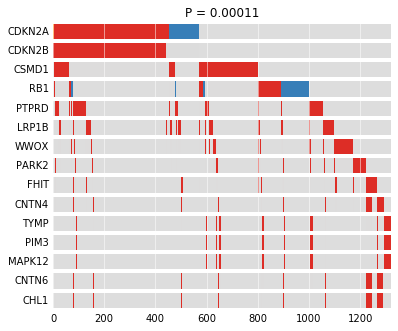

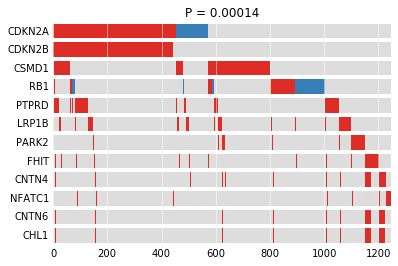

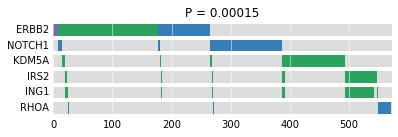

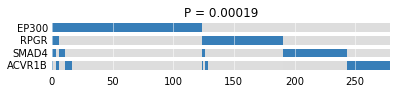

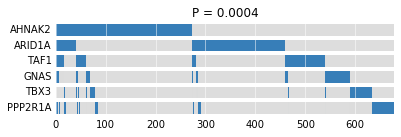

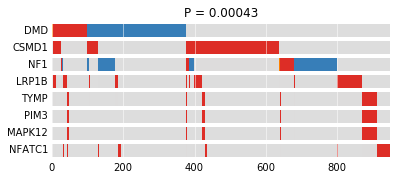

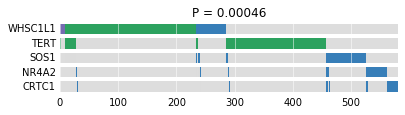

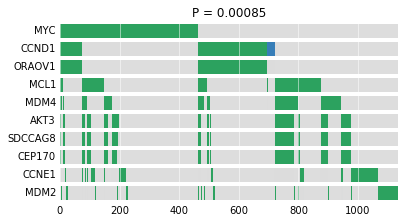

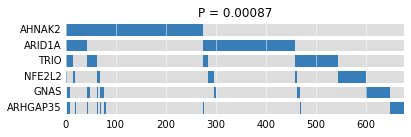

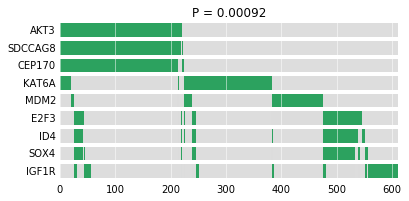

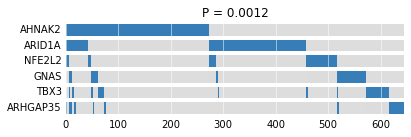

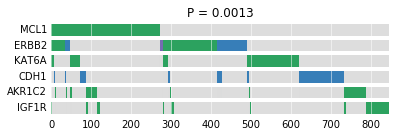

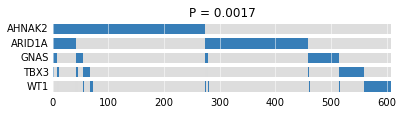

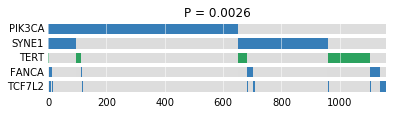

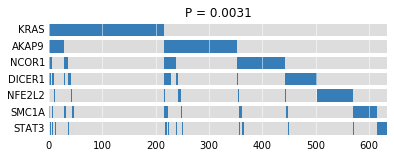

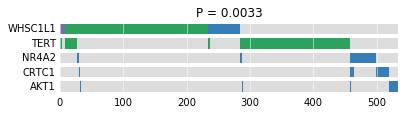

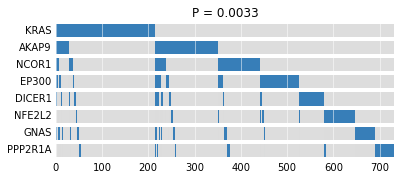

In [34]:
order = pValues.argsort()
sig_gene_sets = order[fdr(pValues[order]) < 0.01]

for i in sig_gene_sets:
    nbsupport.plots.event_plot(events[numpy.concatenate(gene_sets[i])])
    plt.title("P = %.2g" % pValues[i])
    plt.show()